In [1]:
from datetime import datetime
from dateutil.parser import parse
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5

In [34]:
df = pd.read_csv('./public/data/raw_data.csv')

df['TAG'] = df['TAG'] == 'NG'
df['MELT_TEMP'] = df['MELT_TEMP'].apply(lambda x: x / 10)
df['MOTORSPEED'] = df['MOTORSPEED'].apply(lambda x: x / 10)
df['STD_DT'] = df['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))

df.index = df['STD_DT']
df.drop(columns='STD_DT', inplace=True)
df.drop(columns='NUM', inplace=True)
df.drop(columns='MELT_WEIGHT', inplace=True) # 이상 유무와 상관관계가 미미함

df

,MELT_TEMP,MOTORSPEED,INSP,TAG
STD_DT,,,,
2020-03-04 00:00:00,48.9,11.6,3.19,False
2020-03-04 00:00:00,43.3,7.8,3.19,False
2020-03-04 00:00:00,46.4,15.4,3.19,False
2020-03-04 00:00:00,37.9,21.2,3.19,False
2020-03-04 00:00:00,79.8,173.6,3.21,False
...,...,...,...,...
2020-04-30 23:59:00,75.5,174.3,3.21,False
2020-04-30 23:59:00,38.5,20.6,3.19,False
2020-04-30 23:59:00,46.5,14.8,3.20,False


In [3]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:00
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   835200 non-null  float64
 1   MOTORSPEED  835200 non-null  float64
 2   INSP        835200 non-null  float64
 3   TAG         835200 non-null  bool   
dtypes: bool(1), float64(3)
memory usage: 26.3 MB


,MELT_TEMP,MOTORSPEED,INSP
count,835200.000000,835200.000000,835200.000000
mean,50.920062,45.978287,3.194853
std,12.827752,63.943641,0.011822
min,30.800000,0.000000,3.170000
25%,43.000000,11.900000,3.190000
50%,46.900000,16.800000,3.190000
75%,50.200000,21.800000,3.200000
max,83.200000,180.400000,3.230000


In [4]:
x_cols = ['MELT_TEMP', 'MOTORSPEED', 'INSP']
y_col = 'TAG'

In [5]:
df[y_col].value_counts()

False    658133
True     177067
Name: TAG, dtype: int64

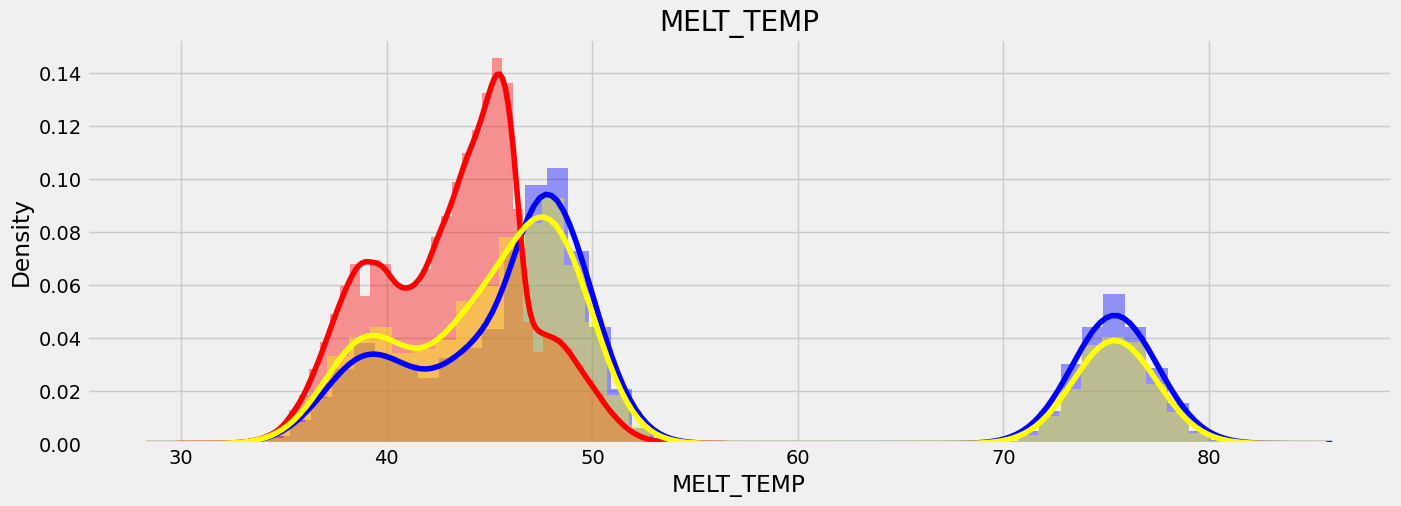

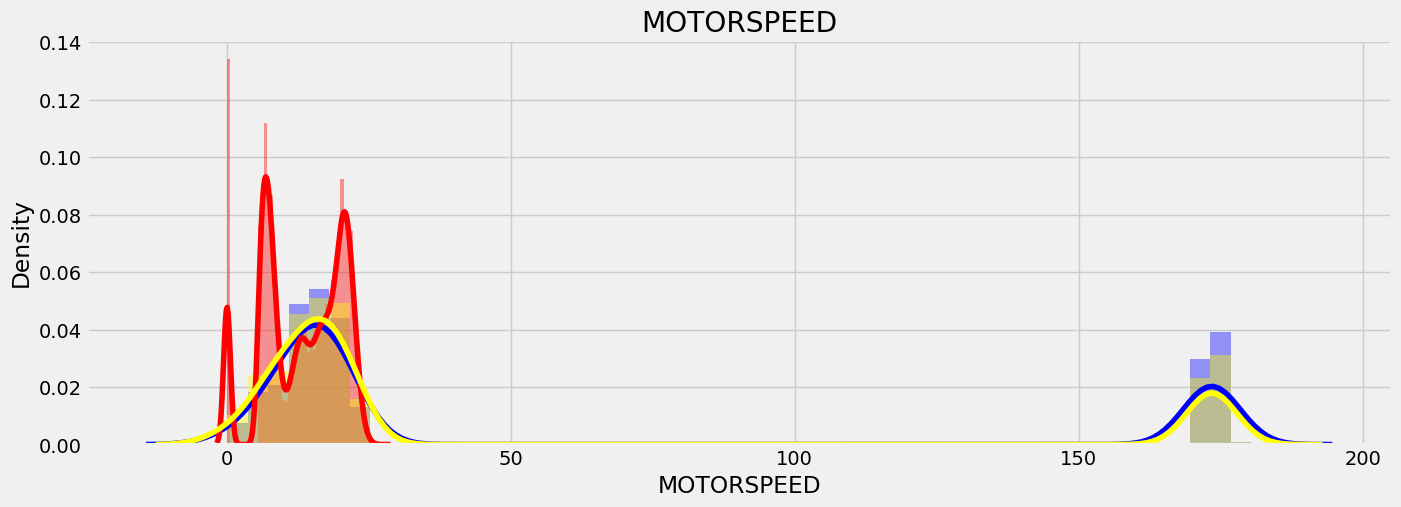

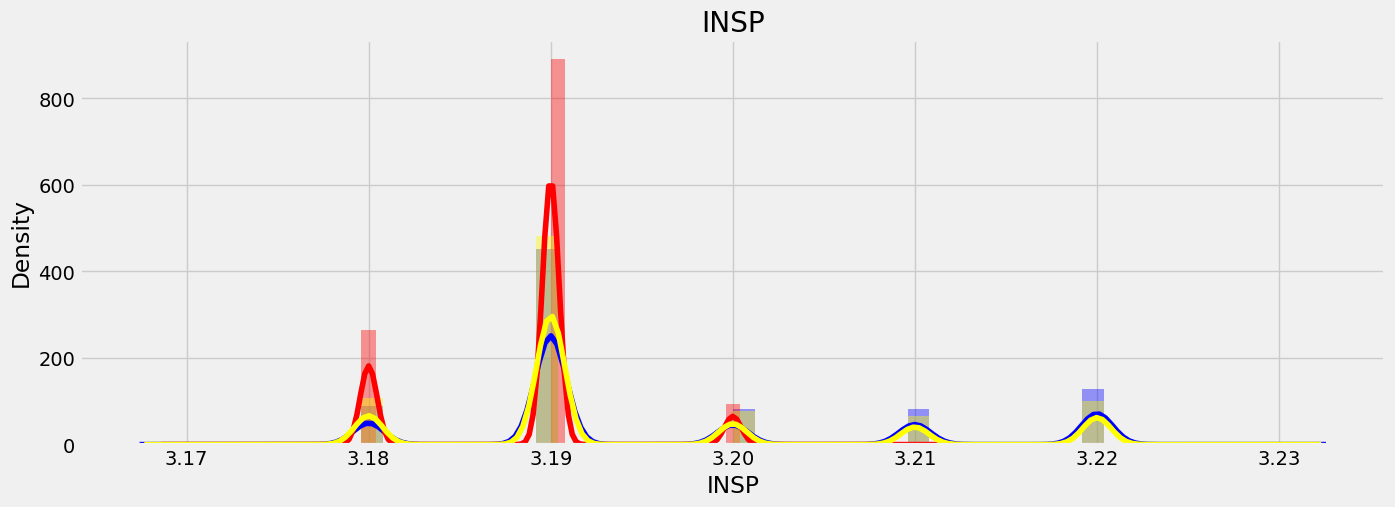

In [6]:
for col in x_cols:
    sns.distplot(df.loc[df[y_col] == False, col], color='blue')
    sns.distplot(df.loc[df[y_col] == True, col], color='red')
    sns.distplot(df[col], color='yellow')
    plt.title(col)
    plt.show()

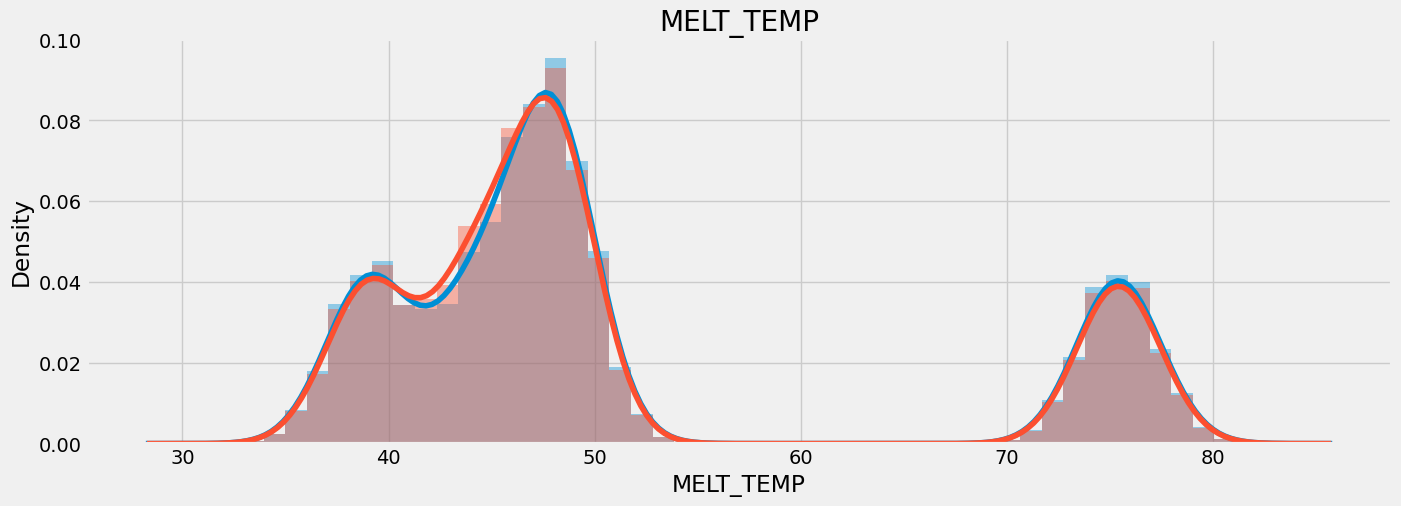

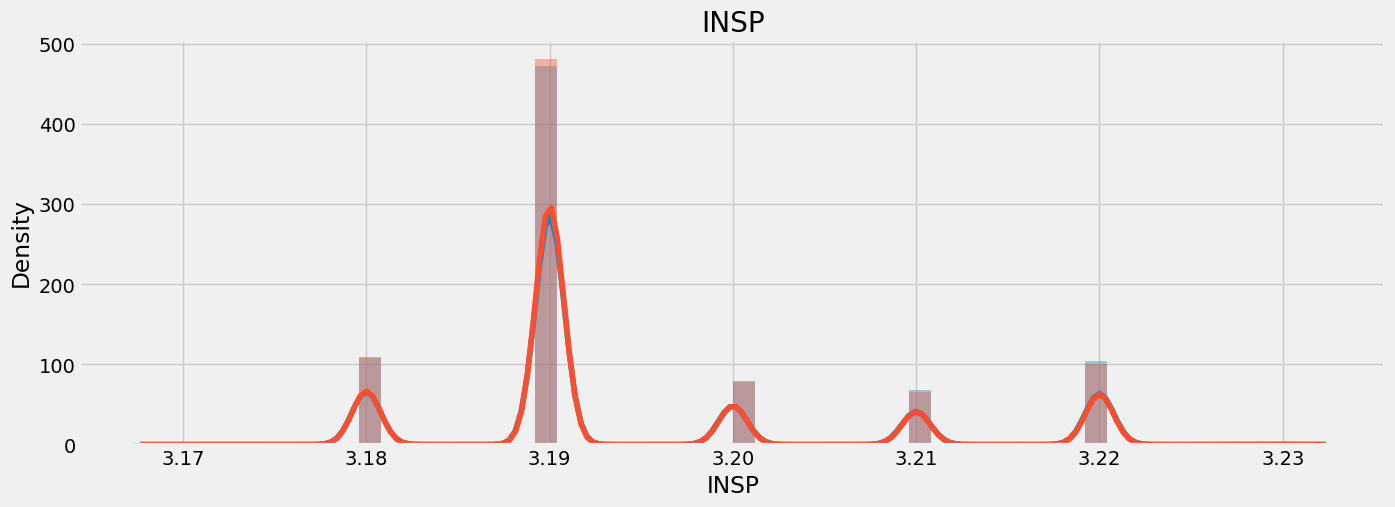

In [7]:
# MOTORSPPED == 0  => 공정완료, 원료 추가 투입, 설비이상 등의 이유로 설비 중지/정지
# MELT_WEIGHT == 0  => 원료 투입 전 혹은 공정 완료 후 탱크가 비어있는 경우

for col in ['MELT_TEMP', 'INSP']:
    # sns.distplot(df.loc[(df['MOTORSPEED'] != 0) & (df['MELT_WEIGHT'] != 0), col])
    sns.distplot(df.loc[(df['MOTORSPEED'] != 0), col])
    sns.distplot(df[col])
    plt.title(col)
    plt.show()

## PCA

In [8]:
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 

x = df.drop(['TAG'], axis=1).values # 독립변인들의 value값만 추출
y = df['TAG'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

pd.DataFrame(x, columns=x_cols).head()

,MELT_TEMP,MOTORSPEED,INSP
0,-0.157476,-0.537634,-0.410480
1,-0.594030,-0.597062,-0.410480
2,-0.352366,-0.478207,-0.410480
3,-1.014992,-0.387502,-0.410480
4,2.251365,1.995848,1.281297


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipal_components = pca.fit_transform(x)
# 주성분으로 이루어진 데이터 프레임 구성
principal_df = pd.DataFrame(data=printcipal_components, columns=['pc1', 'pc2']) 

In [10]:
principal_df['TAG'] = df['TAG'].values

In [11]:
pca.explained_variance_ratio_

array([0.94429631, 0.03884325])

In [12]:
sum(pca.explained_variance_ratio_)

0.9831395550891158

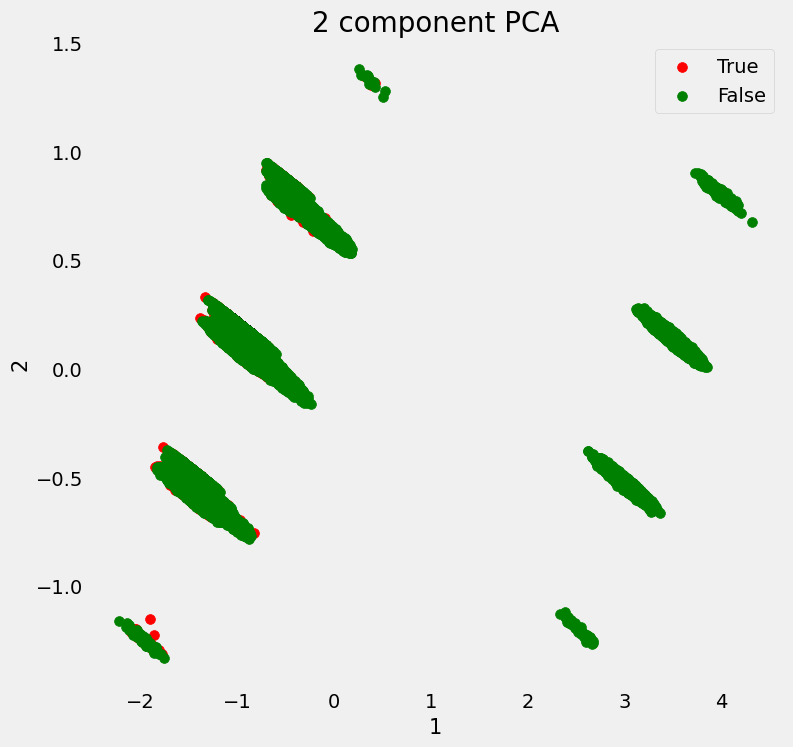

In [13]:
final_df = principal_df

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('1', fontsize = 15)
ax.set_ylabel('2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [True, False]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['TAG'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'pc1']
               , final_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [14]:
# pc 1 >= 0.5일떄 모두 정상임.

final_df[(final_df['pc1'] >= 0.5) & (final_df['TAG'] == True)]

,pc1,pc2,TAG


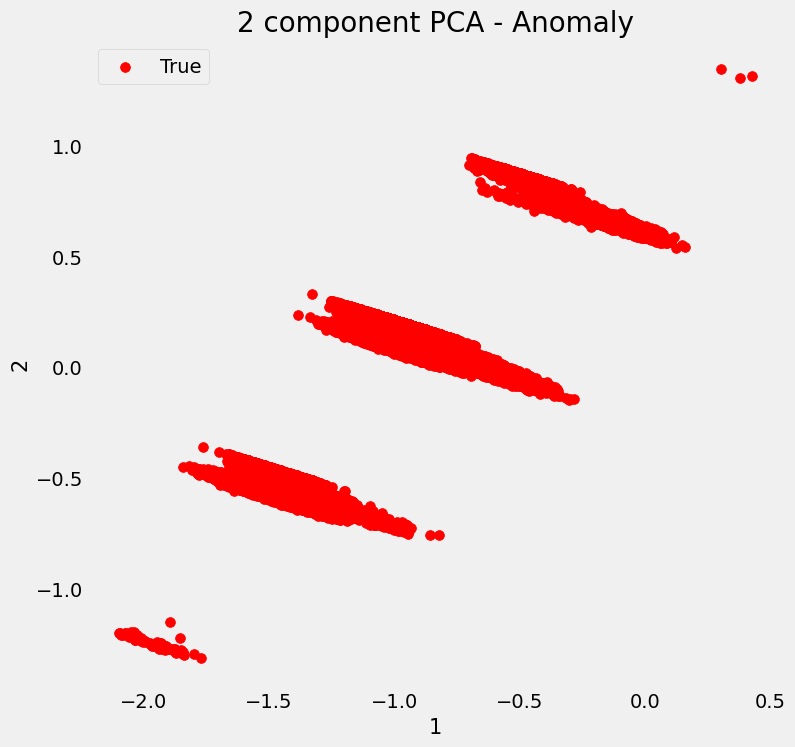

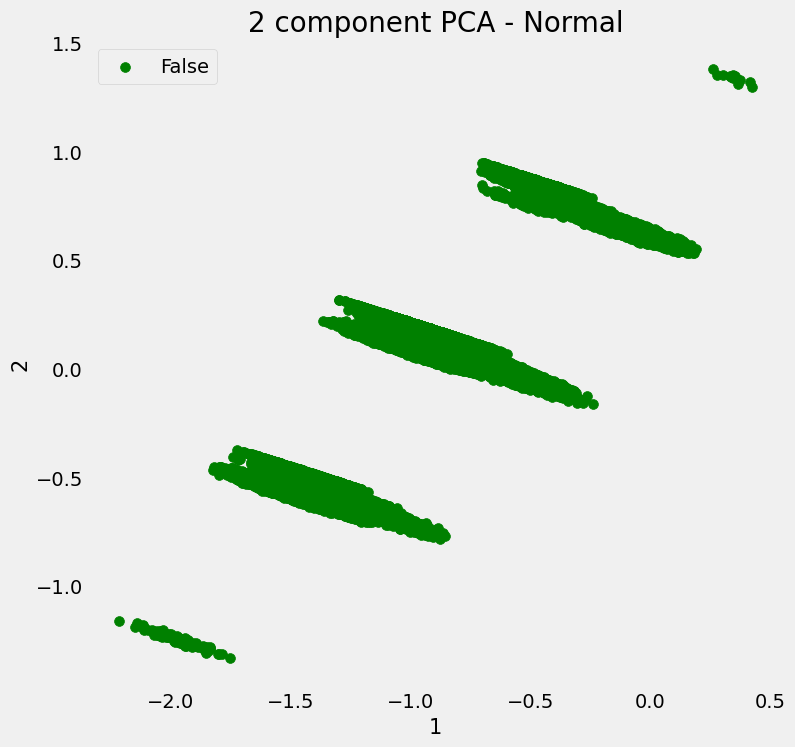

In [15]:
detail_df = final_df[(final_df['pc1'] < 0.5)]

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('1', fontsize = 15)
ax.set_ylabel('2', fontsize = 15)
ax.set_title('2 component PCA - Anomaly', fontsize=20)

targets = [True]
for target, color in zip(targets,colors):
    indicesToKeep = detail_df['TAG'] == target
    ax.scatter(
        detail_df.loc[indicesToKeep, 'pc1'],
        detail_df.loc[indicesToKeep, 'pc2'],
        c = 'r',
        s = 50
    )
ax.legend(targets)
ax.grid()

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('1', fontsize = 15)
ax.set_ylabel('2', fontsize = 15)
ax.set_title('2 component PCA - Normal', fontsize=20)

targets = [False]
for target, color in zip(targets,colors):
    indicesToKeep = detail_df['TAG'] == target
    ax.scatter(
        detail_df.loc[indicesToKeep, 'pc1'],
        detail_df.loc[indicesToKeep, 'pc2'],
        c = 'g',
        s = 50
    )
ax.legend(targets)
ax.grid()

## 계절성 분석

<Figure size 1500x500 with 0 Axes>

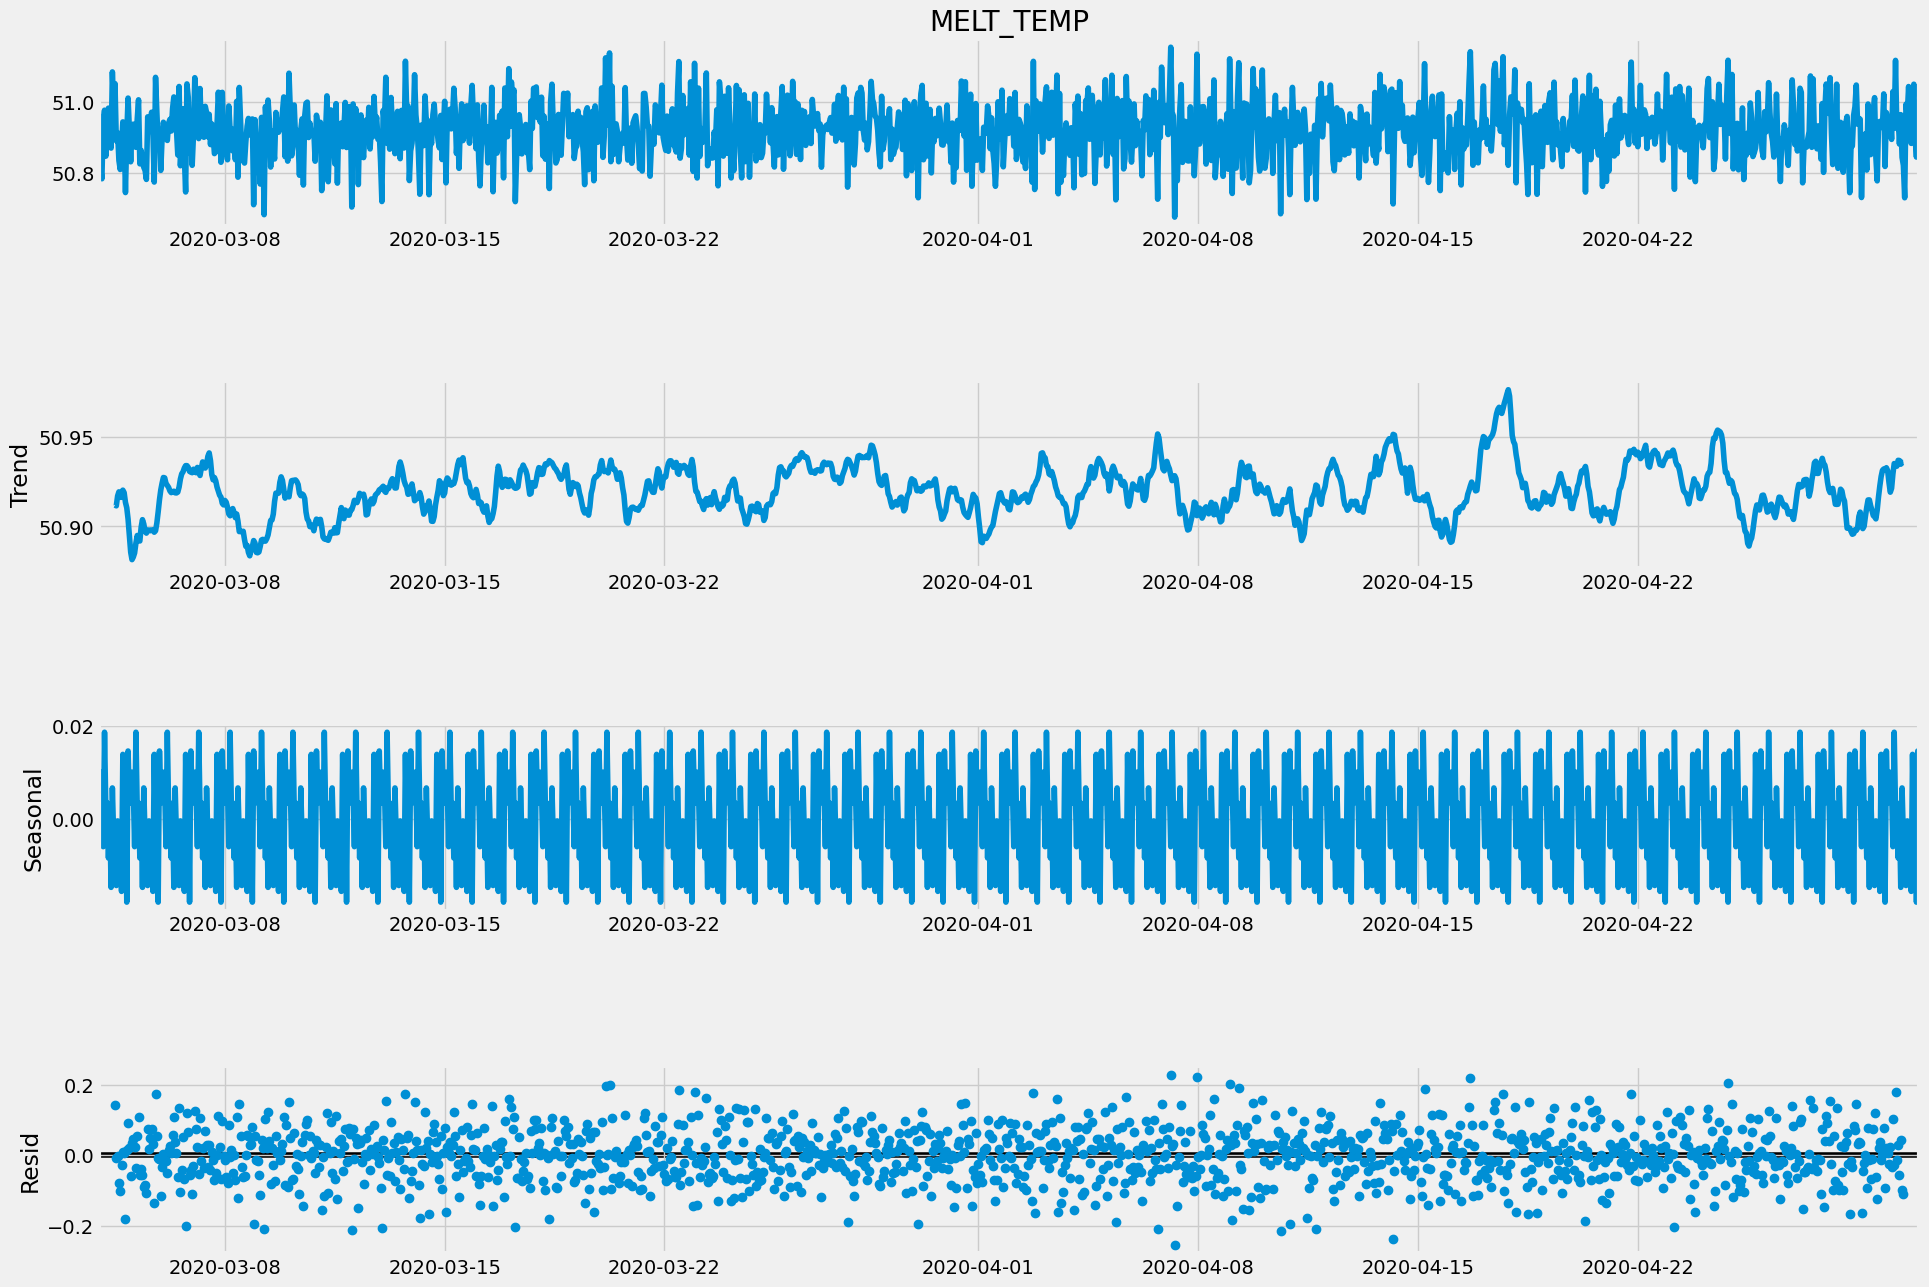

<Figure size 1500x500 with 0 Axes>

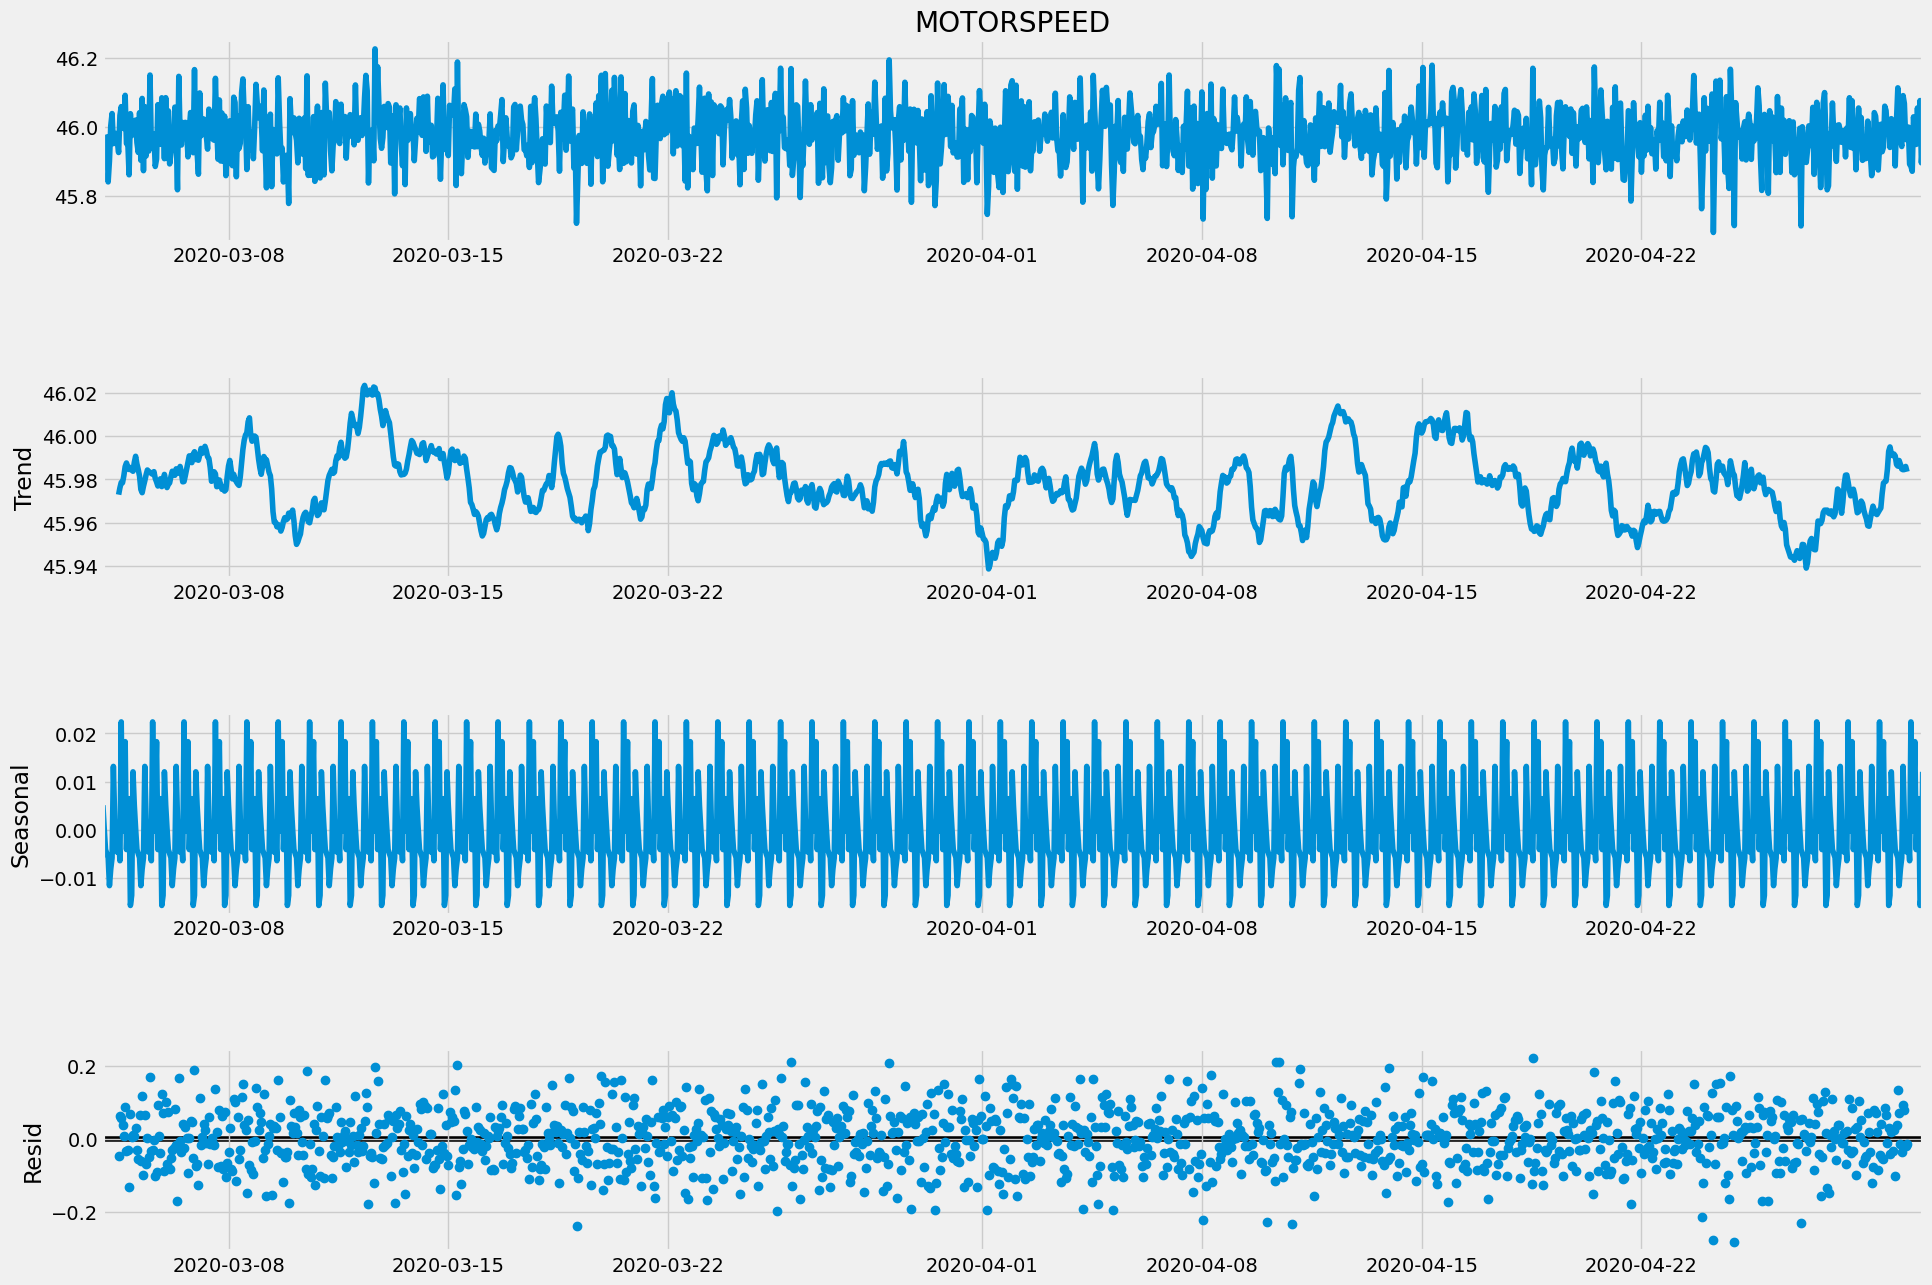

<Figure size 1500x500 with 0 Axes>

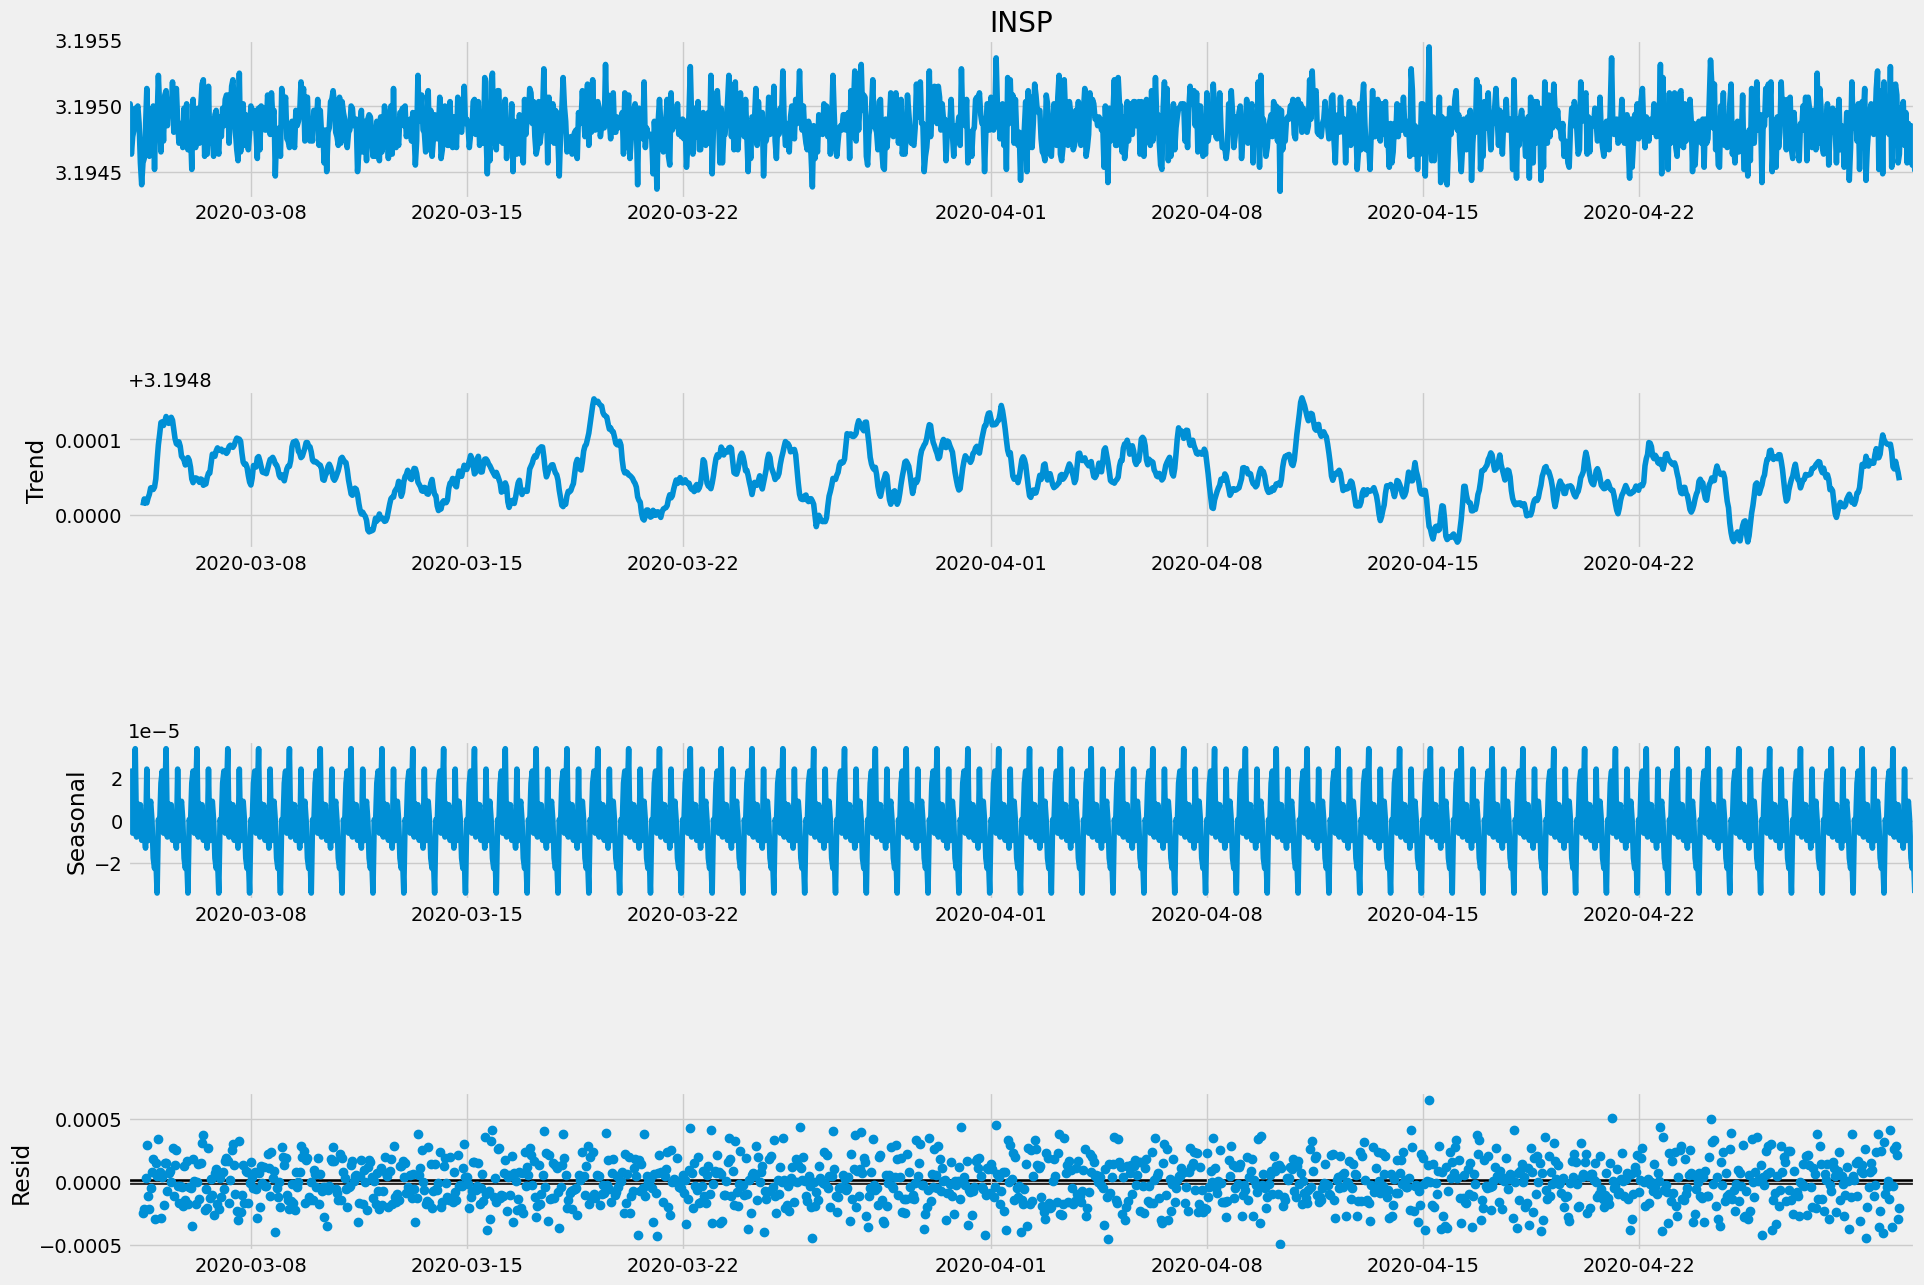

In [171]:
df_ = df.copy(False)
tmp_index = df_.index

def convert(a):
    return f'{"{:02d}".format(a[0])}-{"{:02d}".format(a[1])}-{"{:02d}".format(a[2])}'

df_['time'] = list(map(convert, list(zip(df.index.month, df.index.day, df.index.hour))))

A = []
B = []

idx = (df_.index.month>=3)
new_index = pd.date_range(start='3/4/2020', end='5/1/2020', freq='H')[:-1]

group_by_day_df = df_[idx].groupby(df_.loc[idx, 'time'])

results = []
for col in x_cols:
    day_mean = pd.DataFrame(group_by_day_df[col].mean())
    day_mean.index = new_index
    result = seasonal_decompose(day_mean[col], model='additive')
    results.append(day_mean)

    fig = plt.figure()
    fig = result.plot()
    fig.set_size_inches(20, 15)

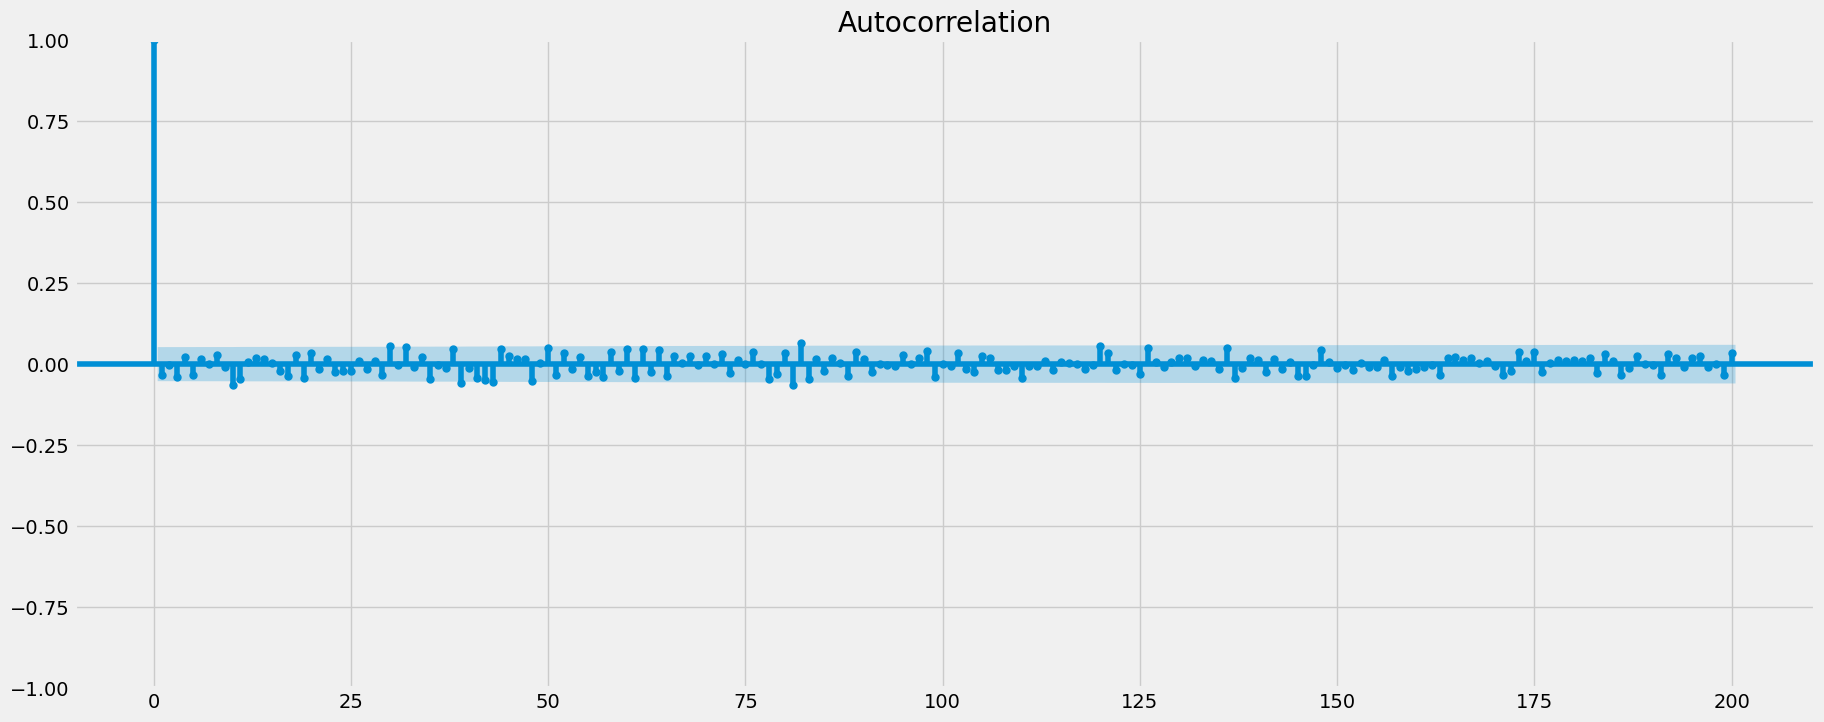

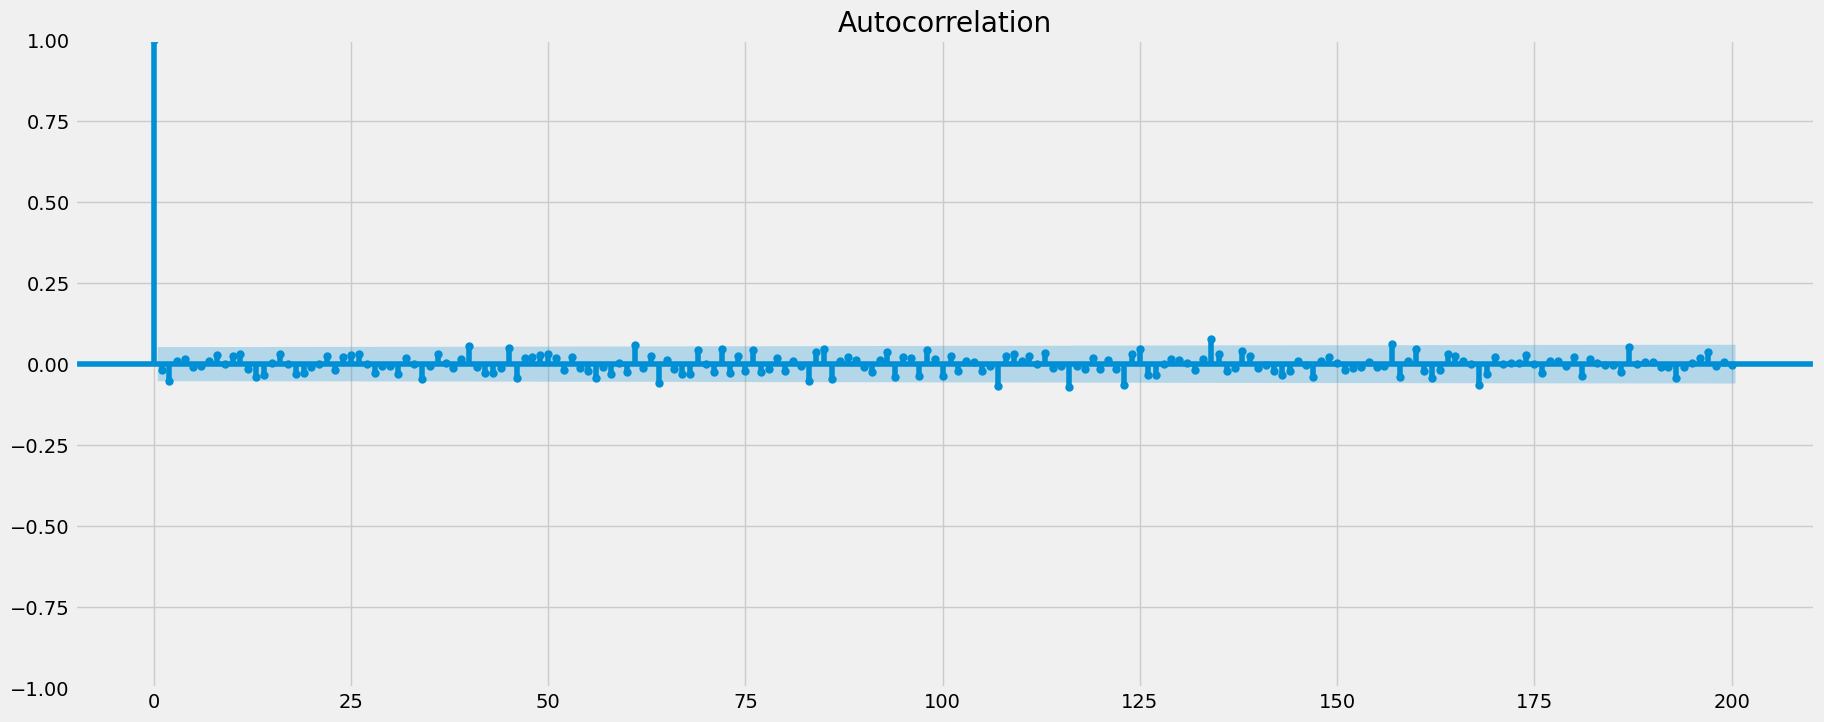

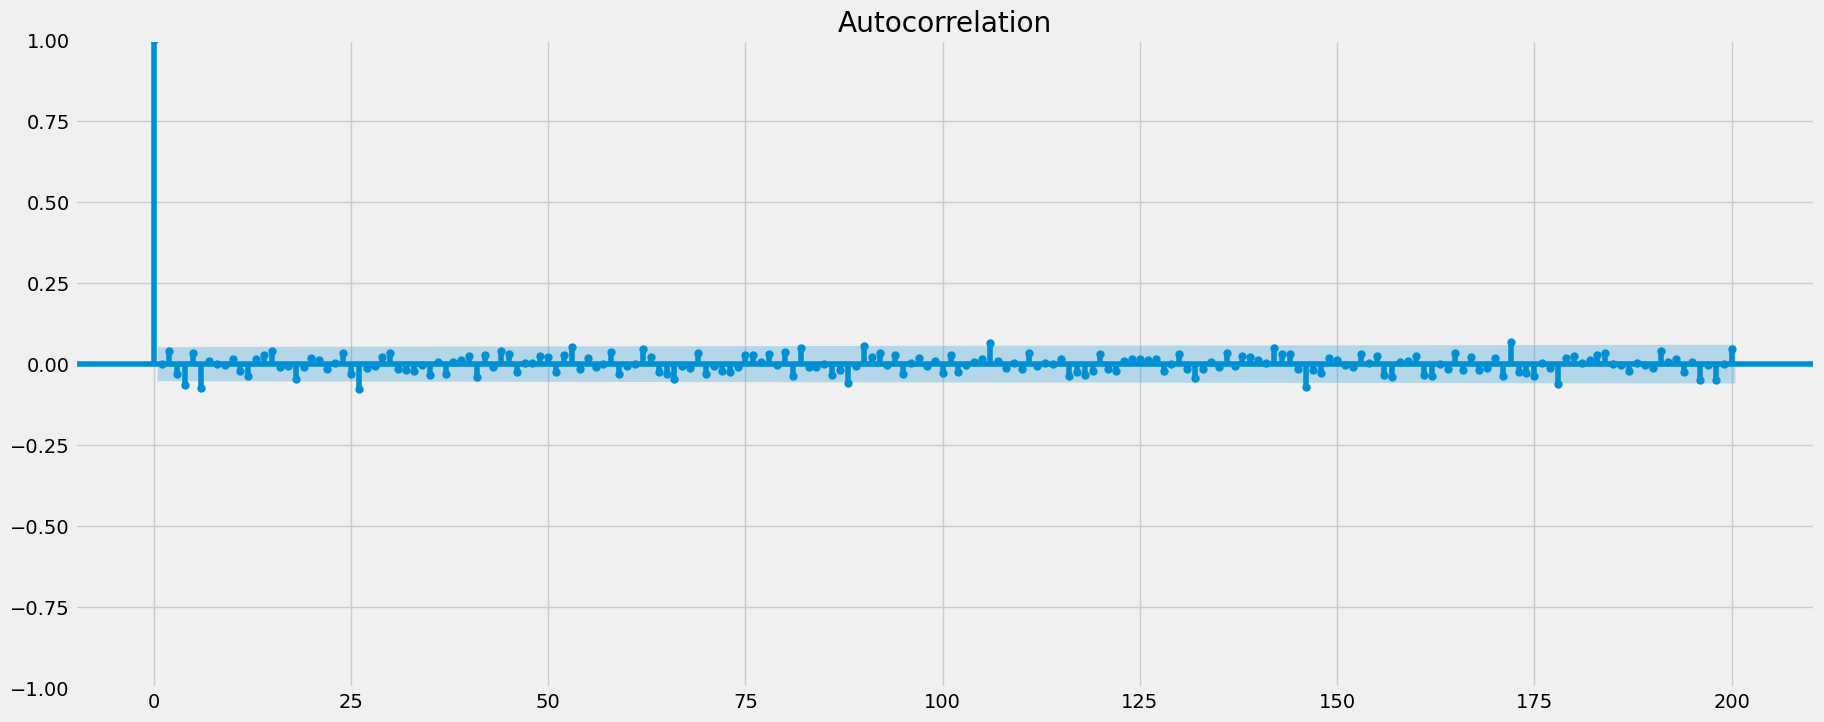

In [172]:
for ts in results:
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(111)
    fig = plot_acf(ts, lags=200, ax=ax1)

In [173]:
for ts in results:
    result = adfuller(ts)
    print("======================")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values: ')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -38.59017565348948
p-value: 0.0
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF Statistic: -28.05654196566474
p-value: 0.0
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF Statistic: -16.42945688362611
p-value: 2.486480019971802e-29
Critical Values: 
	1%: -3.435
	5%: -2.864
	10%: -2.568


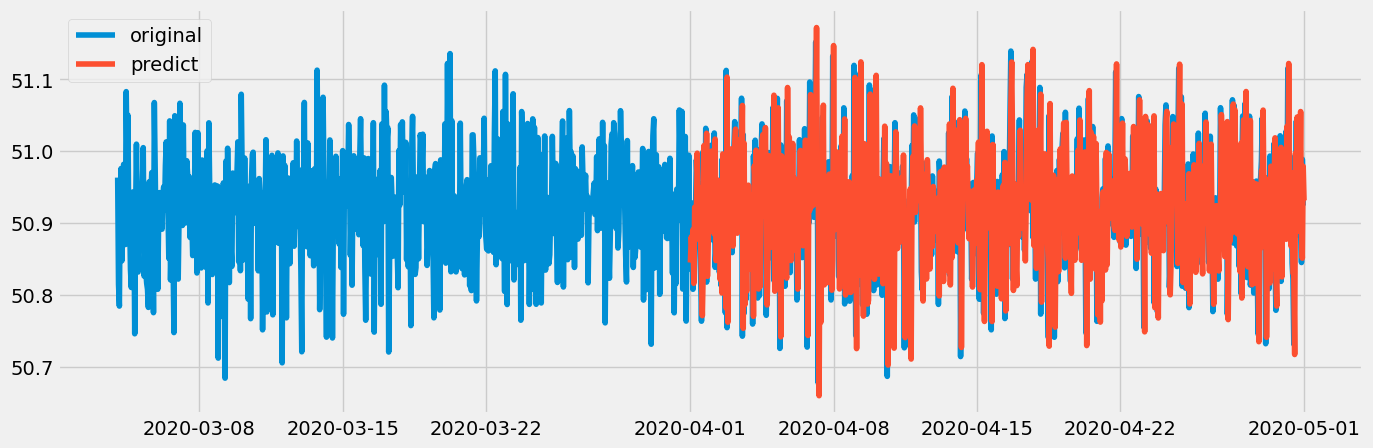

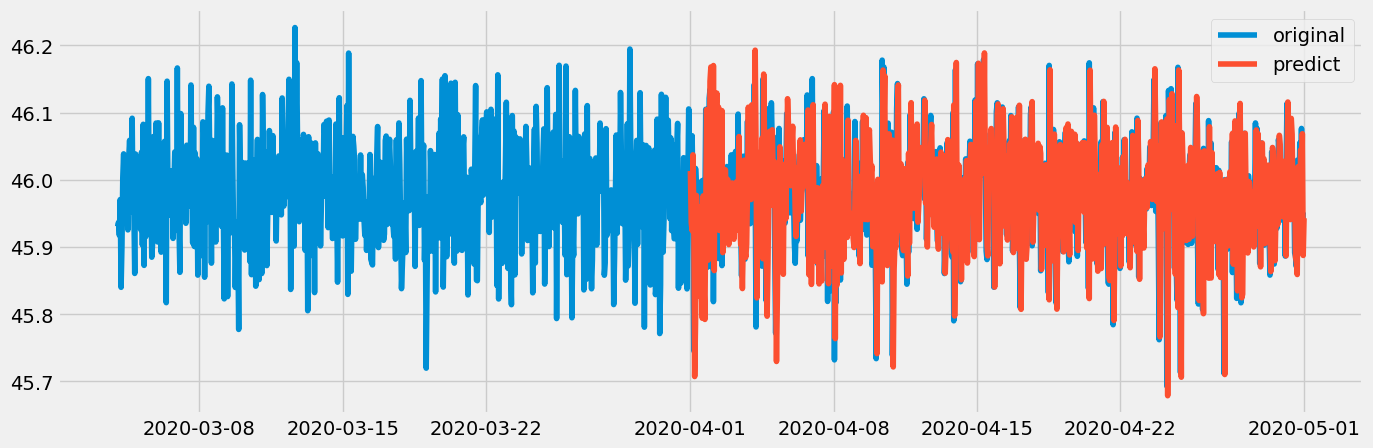

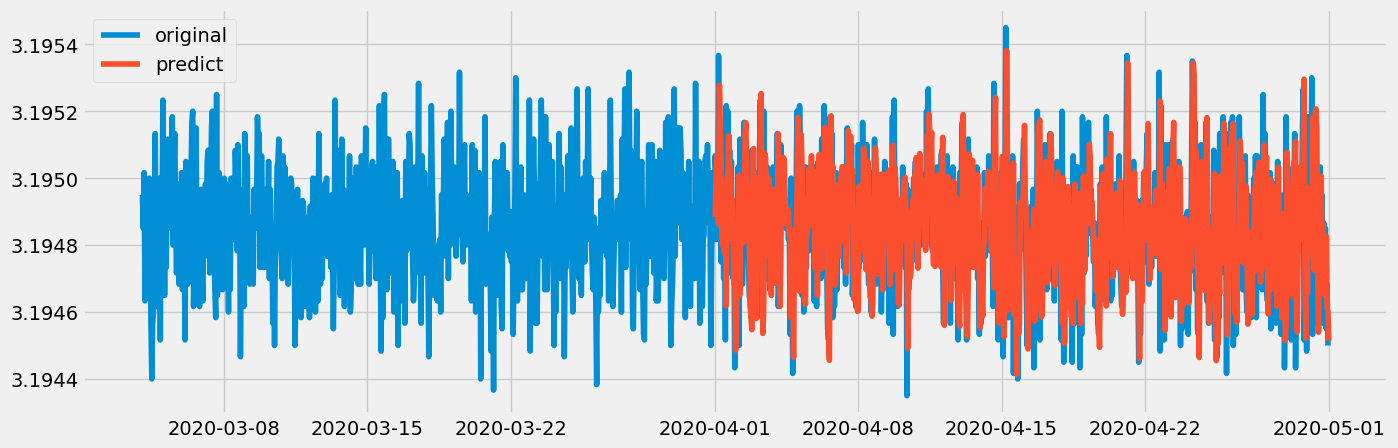

In [205]:
from statsmodels.tsa.arima.model import ARIMA

orders = [(1, 4, 4), (1, 4, 4), (1, 2, 1)]

predicts = []

for i, ts in enumerate(results):
    model = ARIMA(ts, order=orders[i])
    model_fit = model.fit()
    
    start_index = pd.datetime(2020, 4, 1)
    end_index = pd.datetime(2020, 5, 1)
    
    forecast = model_fit.predict(start=start_index, end=end_index)
    
    predicts.append((start_index, forecast))
    
    plt.plot(ts, label='original')
    plt.plot(forecast, label='predict')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


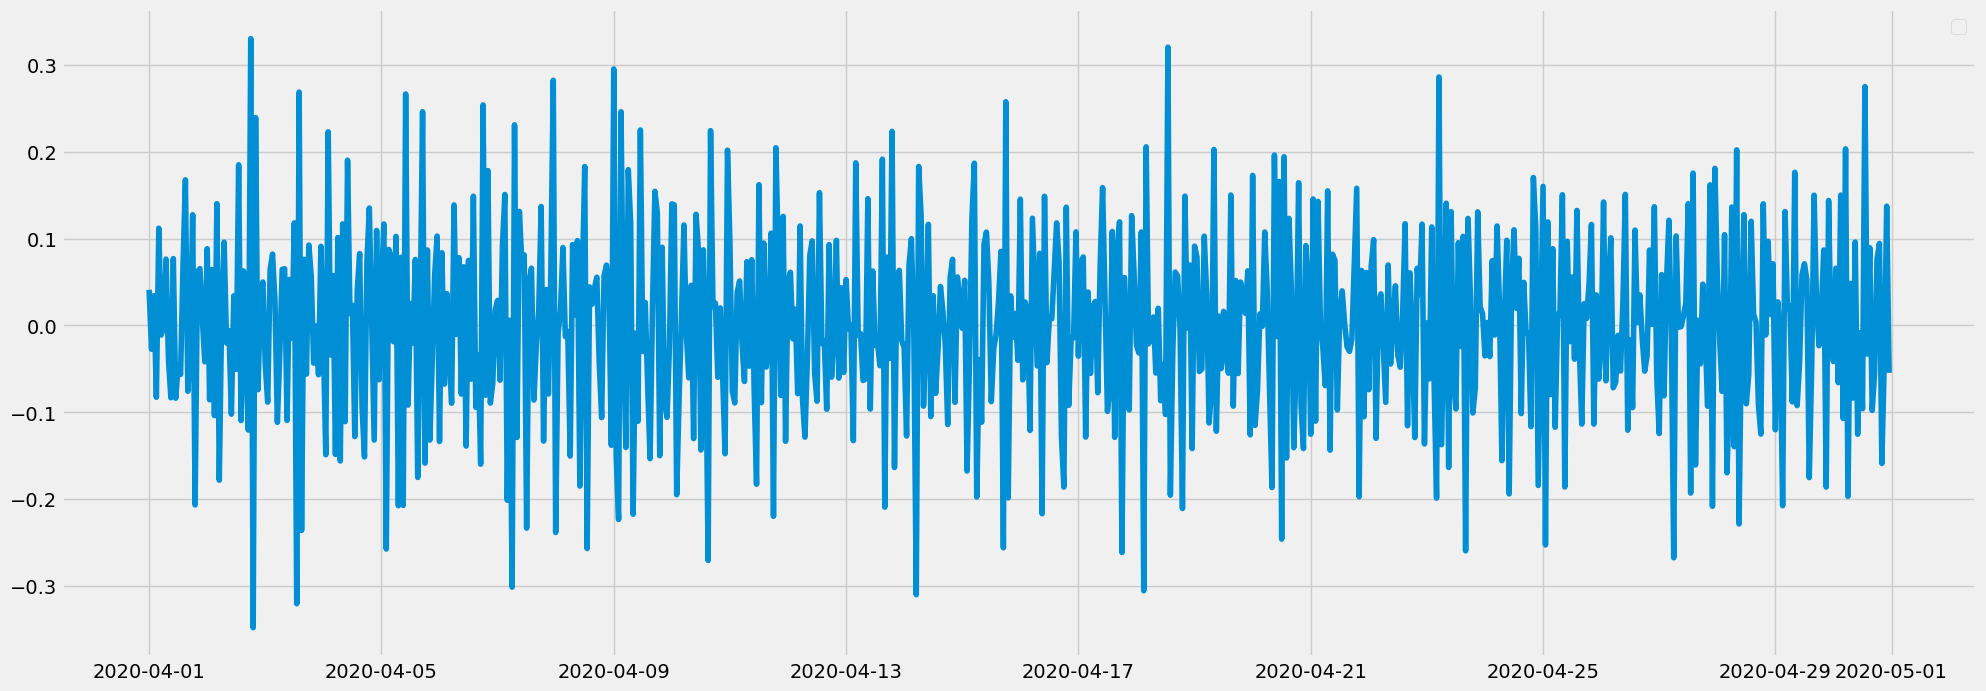

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


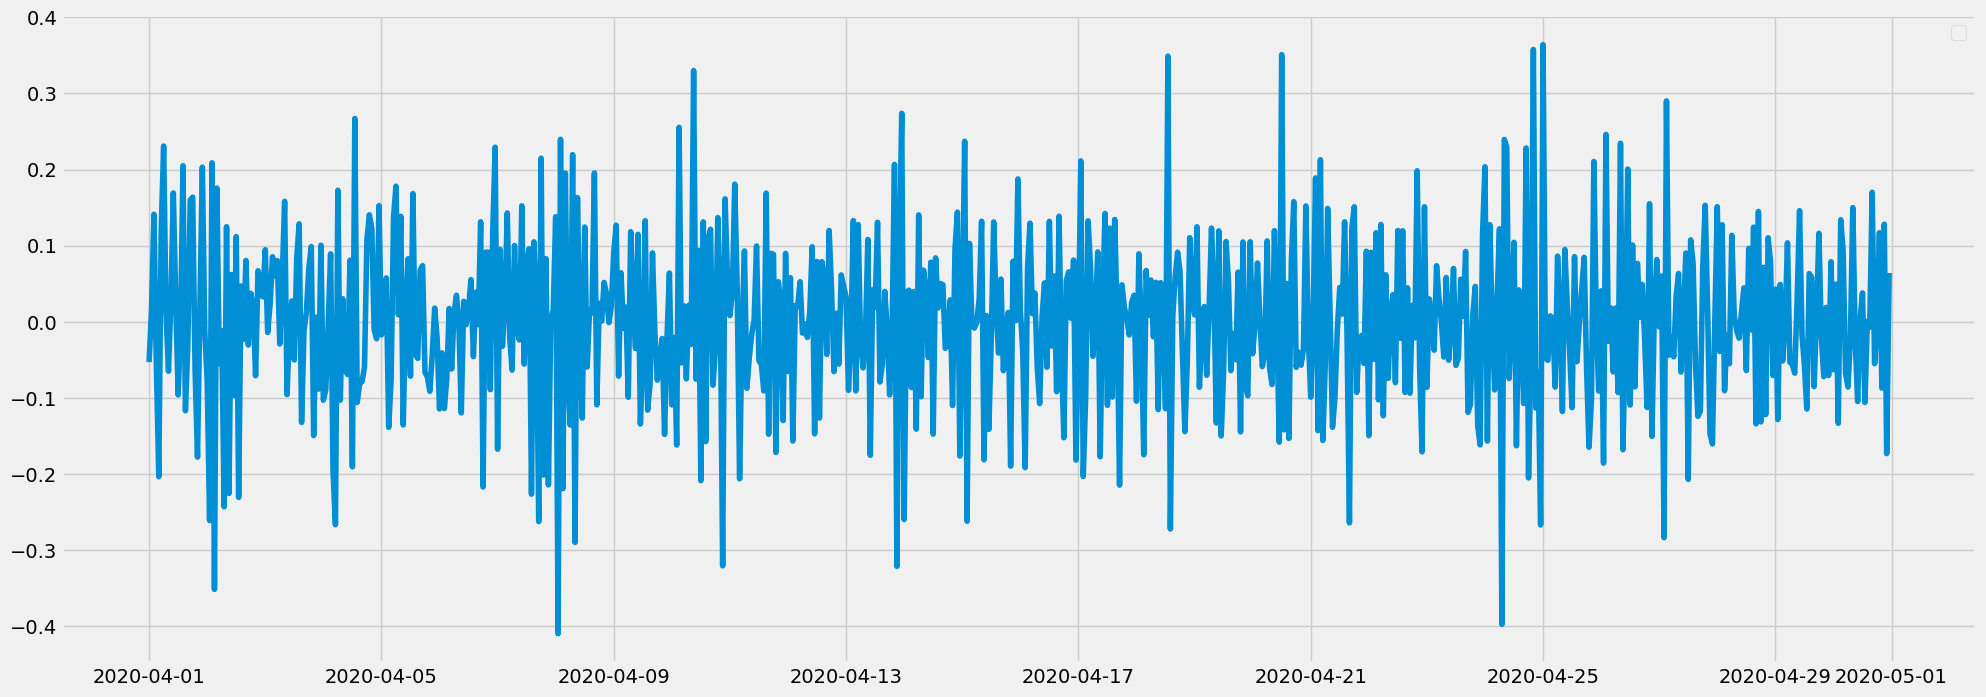

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


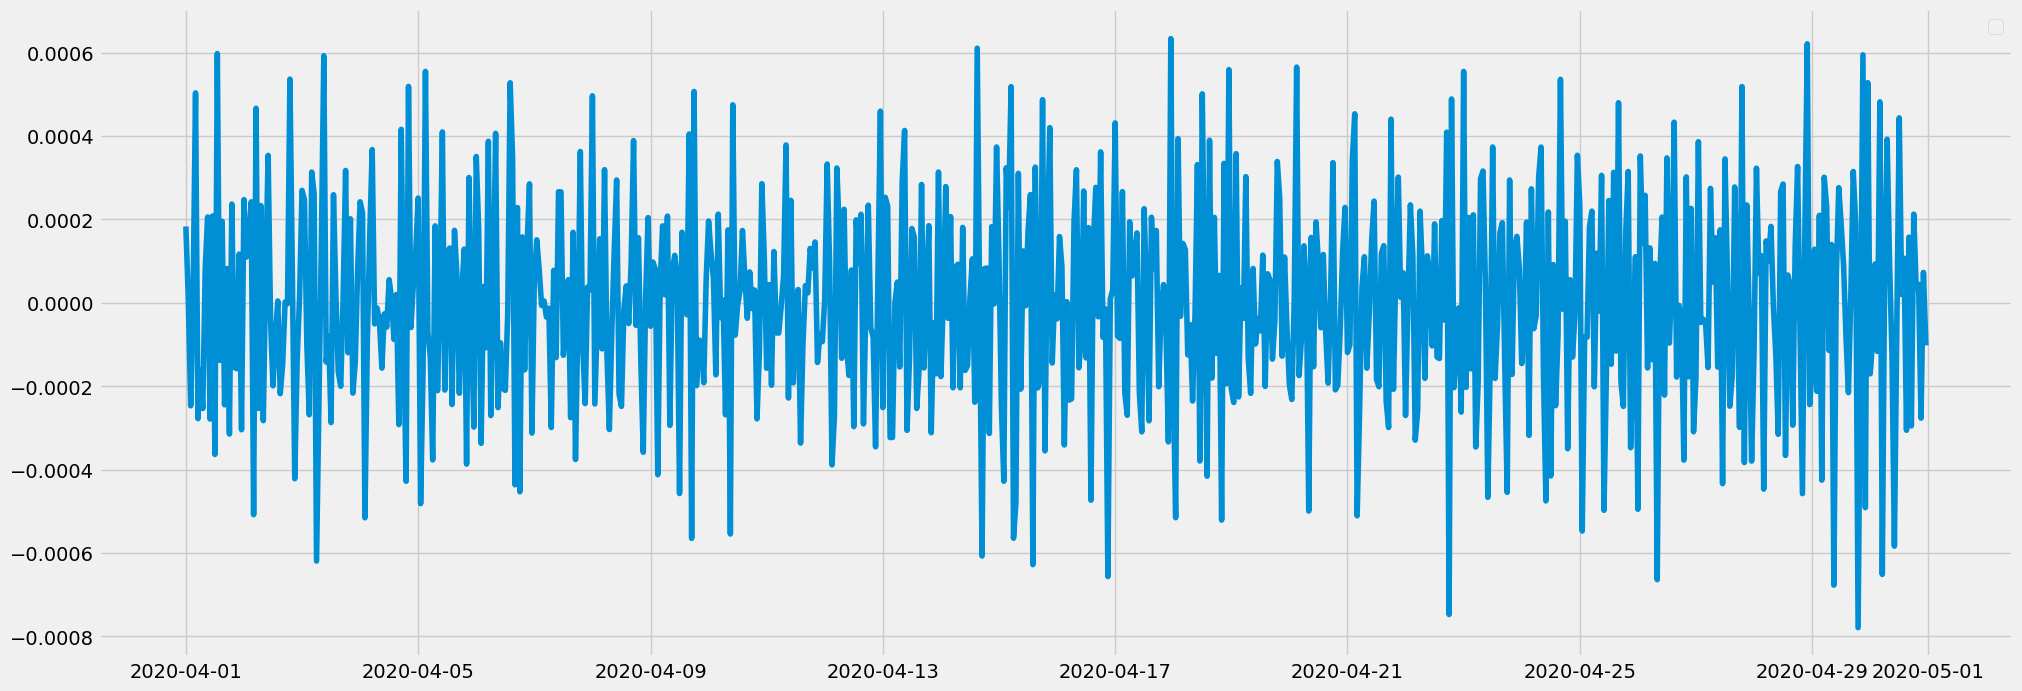

In [212]:
for ts, predict in zip(results, predicts):
    l = ts[ts.index >= predict[0]].values.squeeze()
    r = predict[1].values[:-1]
    resi = l - r
    
    plt.figure(figsize=(22, 8))
    plt.plot(ts[ts.index >= predict[0]].index, resi)
    plt.legend()
    plt.show()